<a href="https://colab.research.google.com/github/vinit6085903/anpr/blob/main/cencer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-histopathology-images' dataset.
Path to dataset files: /kaggle/input/breast-histopathology-images


In [ ]:
import os
print(os.listdir(path))

['10295', '10304', '12868', '10274', '12818', '14190', '12869', '9323', '10291', '12906', '9176', '8984', '10299', '12930', '9344', '12935', '12894', '12909', '9381', '9346', '9175', '10262', '8980', '16896', '12241', '12910', '13617', '13401', '12891', '10300', '9076', '10259', '9124', '13402', '12870', '16550', '10255', '9261', '15471', '12931', '12955', '10258', '13461', '13023', '9260', '8957', '9035', '10268', '13403', '10288', '9262', '12911', '9319', '10254', '13616', '10253', '8974', '9135', '10257', '9291', '9320', '14209', '14078', '12749', '9043', '9041', '8975', '9075', '13025', '13021', '13458', '12901', '16552', '13688', '15902', '13692', '12879', '9073', '15514', '9325', '10277', '12810', '8864', '8917', '14305', '16167', '13022', '16555', '12932', '14189', '8867', '16166', '10290', '9083', '15840', '12907', '12880', '12908', '13693', '13591', '15516', '9228', '14192', '12949', '10306', '9345', '14156', '12872', '9123', '13019', '9226', '14304', '10260', '14154', '15472'

In [ ]:
import os

patient_path = os.path.join(path, "10295")
print(os.listdir(patient_path))

['0', '1']


In [ ]:
import os
import shutil
import random

In [ ]:
# KaggleHub se jo path mila tha
SOURCE_DIR = path   # breast-histopathology-images

TARGET_DIR = "dataset"

TRAIN_DIR = os.path.join(TARGET_DIR, "train")
TEST_DIR  = os.path.join(TARGET_DIR, "test")

NORMAL_TRAIN = os.path.join(TRAIN_DIR, "normal")
CANCER_TRAIN = os.path.join(TRAIN_DIR, "cancer")
NORMAL_TEST  = os.path.join(TEST_DIR, "normal")
CANCER_TEST  = os.path.join(TEST_DIR, "cancer")

In [ ]:
for folder in [
    NORMAL_TRAIN, CANCER_TRAIN,
    NORMAL_TEST, CANCER_TEST
]:
    os.makedirs(folder, exist_ok=True)

In [ ]:
def split_and_copy_images(source_folder, train_folder, test_folder, split_ratio=0.8):
    images = os.listdir(source_folder)
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)

    train_images = images[:split_index]
    test_images = images[split_index:]

    for img in train_images:
        shutil.copy(
            os.path.join(source_folder, img),
            os.path.join(train_folder, img)
        )

    for img in test_images:
        shutil.copy(
            os.path.join(source_folder, img),
            os.path.join(test_folder, img)
        )

In [ ]:
patient_folders = os.listdir(SOURCE_DIR)

for patient in patient_folders:
    patient_path = os.path.join(SOURCE_DIR, patient)

    if not os.path.isdir(patient_path):
        continue

    # Normal images (0)
    normal_path = os.path.join(patient_path, "0")
    if os.path.exists(normal_path):
        split_and_copy_images(
            normal_path,
            NORMAL_TRAIN,
            NORMAL_TEST
        )

    # Cancer images (1)
    cancer_path = os.path.join(patient_path, "1")
    if os.path.exists(cancer_path):
        split_and_copy_images(
            cancer_path,
            CANCER_TRAIN,
            CANCER_TEST
        )

In [ ]:
print("Train Normal:", len(os.listdir(NORMAL_TRAIN)))
print("Train Cancer:", len(os.listdir(CANCER_TRAIN)))
print("Test Normal :", len(os.listdir(NORMAL_TEST)))
print("Test Cancer :", len(os.listdir(CANCER_TEST)))

Train Normal: 158881
Train Cancer: 62917
Test Normal : 39857
Test Cancer : 15869


In [ ]:
from PIL import Image
import os


img_path = os.path.join(NORMAL_TRAIN, os.listdir(NORMAL_TRAIN)[0])

img = Image.open(img_path)
print("Image Size (Width x Height):", img.size)
print("Image Mode:", img.mode)

Image Size (Width x Height): (50, 13)
Image Mode: RGB


In [ ]:
import cv2

img = cv2.imread(img_path)
print("Image Shape (H, W, C):", img.shape)

Image Shape (H, W, C): (13, 50, 3)


In [ ]:
sizes = set()

for img_name in os.listdir(NORMAL_TRAIN)[:100]:  # first 100 images
    img = Image.open(os.path.join(NORMAL_TRAIN, img_name))
    sizes.add(img.size)

print("Unique image sizes:", sizes)

Unique image sizes: {(50, 50), (50, 13), (50, 43)}


In [ ]:
sizes = set()

for img_name in os.listdir(NORMAL_TRAIN)[:100]:  # first 100 images
    img = Image.open(os.path.join(NORMAL_TRAIN, img_name))
    sizes.add(img.size)

print("Unique image sizes:", sizes)

Unique image sizes: {(50, 50), (50, 13), (50, 43)}


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [ ]:


IMG_SIZE = 128
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_data = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 221798 images belonging to 2 classes.
Found 55726 images belonging to 2 classes.


In [ ]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=1000,
    validation_data=test_data,
    validation_steps=300
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 450s 438ms/step - accuracy: 0.7134 - loss: 0.6073 - val_accuracy: 0.0000e+00 - val_loss: 1.1747
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 442s 442ms/step - accuracy: 0.7220 - loss: 0.5953 - val_accuracy: 0.0000e+00 - val_loss: 1.2483
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 502s 502ms/step - accuracy: 0.7085 - loss: 0.6074 - val_accuracy: 0.0000e+00 - val_loss: 1.2293
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 440s 440ms/step - accuracy: 0.7187 - loss: 0.6005 - val_accuracy: 0.0000e+00 - val_loss: 1.2177
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 430s 430ms/step - accuracy: 0.7172 - loss: 0.6024 - val_accuracy: 0.0000e+00 - val_loss: 1.2458


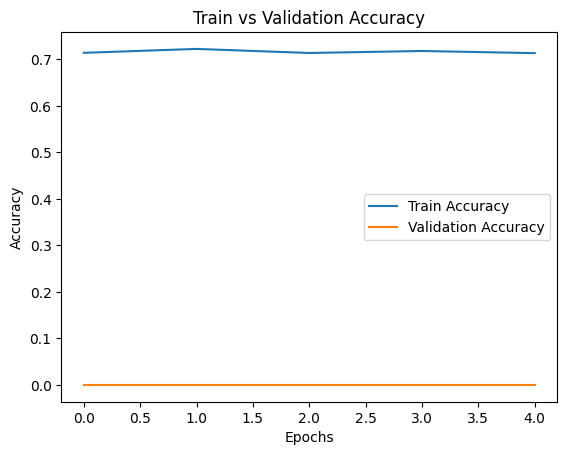

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_data)
test_loss, test_acc = model.evaluate(test_data)

print(f"Train Accuracy : {train_acc*100:.2f}%")
print(f"Test Accuracy  : {test_acc*100:.2f}%")

13863/13863 ━━━━━━━━━━━━━━━━━━━━ 4715s 340ms/step - accuracy: 0.7146 - loss: 0.5977
3483/3483 ━━━━━━━━━━━━━━━━━━━━ 998s 286ms/step - accuracy: 0.3578 - loss: 0.9214
Train Accuracy : 71.63%
Test Accuracy  : 71.52%


3483/3483 ━━━━━━━━━━━━━━━━━━━━ 1033s 296ms/step


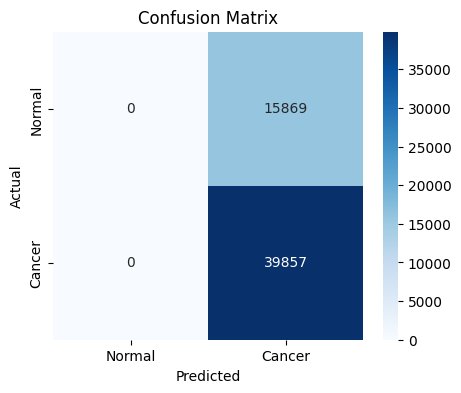

In [ ]:
y_true = test_data.classes
y_pred_prob = model.predict(test_data)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Normal", "Cancer"],
            yticklabels=["Normal", "Cancer"],
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=["Normal", "Cancer"]
))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00     15869
      Cancer       0.72      1.00      0.83     39857

    accuracy                           0.72     55726
   macro avg       0.36      0.50      0.42     55726
weighted avg       0.51      0.72      0.60     55726



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


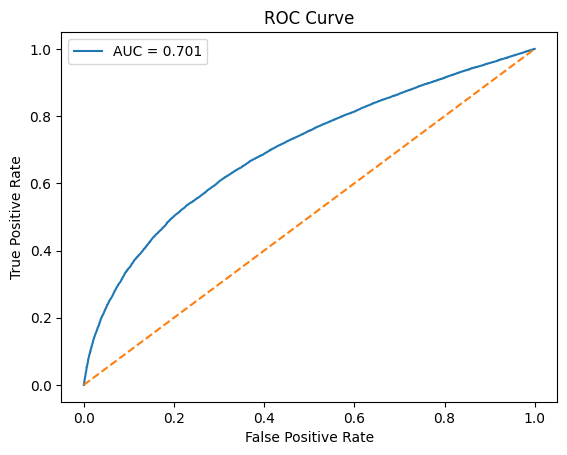

ROC-AUC Score: 0.7006229346604513


In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC-AUC Score:", roc_auc)

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
last_conv_layer_name = "top_conv"

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = os.path.join(CANCER_TEST, os.listdir(CANCER_TEST)[0])

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

In [ ]:
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer_name
)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


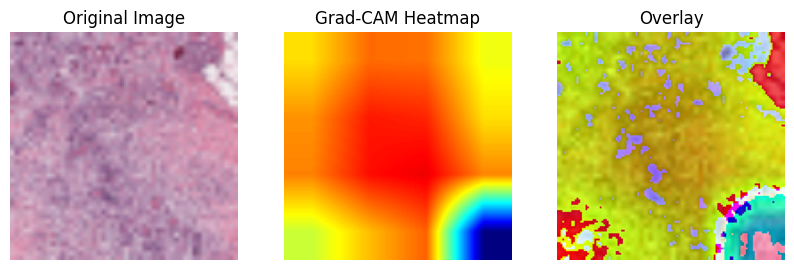

In [ ]:
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(cv2.cvtColor(superimposed_img.astype("uint8"), cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

In [ ]:
# #Color	Matlab
# 🔴 Red	Sabse important area
# 🟡 Yellow	Medium importance
# 🟢 Green	Low importance
# 🔵 Blue	Bahut kam importance